In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchsummary
from seaborn.external.docscrape import header

import utils.audio_utils
from utils.preprocess import LyricPreprocessor
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from torch.utils.data import DataLoader
import torchvision.models as models
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns

/Users/julia.rozycka/Master/Multimodal Genre Classifier/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data from csv for lyrics
df = pd.read_csv('data/fma_cut100_echonest_lyrics_fake_country.csv', header=[0, 1])
df.sort_values(('track', 'one_genre'), inplace=True)

In [3]:
df = df[df['track', 'language_code'].isin(['en', np.nan])]

In [4]:
df.sample()

track    album                                                         \
    track_id comments         date_created        date_released     engineer   
215     5119        0  2009-01-15 14:08:22  2009-01-15 00:00:00  Trent Wolbe   

                                                                        \
    favorites    id                                        information   
215         3  1803  <p>To mark the release of her new recording, <...   

                             ...     track                                     \
    listens        producer  ... one_genre danceability    energy speechiness   
215    5442  Scott McDowell  ...      Jazz     0.403479  0.472846    0.096352   

                                                                            
    acousticness instrumentalness  liveness   valence   tempo track_folder  
215     0.802309         0.920348  0.135067  0.288152  74.331            5  

[1 rows x 67 columns]

## Lyrics

In [5]:
# Preprocess the lyrics
lyrics = ('track', 'lyrics')

lyricPreprocessor = LyricPreprocessor(lyrics=lyrics)
df_lyrics = lyricPreprocessor.preprocess_lyrics(df, ('track', 'lemmatized_lyrics'))

Handling contractions: 100%|██████████| 568/568 [00:00<00:00, 32481.18it/s]
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julia.rozycka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/julia.rozycka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julia.rozycka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/julia.rozycka/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|██████████| 568/568 [00:01<00:00, 334.70it/s]


In [6]:
df_lyrics

track    album                                            \
    track_id comments         date_created        date_released   
576    91935        0  2013-10-10 16:33:42  2013-09-28 00:00:00   
543    12917        0  2009-05-14 07:10:28                  NaN   
542    12915        0  2009-05-14 07:10:28                  NaN   
541    12902        0  2009-05-14 07:10:28                  NaN   
540    12885        0  2009-05-14 07:10:28                  NaN   
..       ...      ...                  ...                  ...   
366    11664        0  2009-04-28 23:58:48                  NaN   
365    33542        1  2010-08-03 19:45:03                  NaN   
364    66655        0  2012-06-19 12:13:52  2012-06-16 00:00:00   
344    47951        5  2011-05-20 16:31:08  2011-04-27 00:00:00   
318     4254        0  2008-12-04 09:29:25  2001-07-19 00:00:00   

                                                      \
                           engineer favorites     id   
576                             NaN         0  15205   
543                             NaN         7   3077   
542                             NaN         7   3077   
541                             NaN         7   3077   
540                             NaN         7   3077   
..                              ...       ...    ...   
366                             NaN         0   2867   
365                             NaN         6   7011   
364  Jason Sigal w/ Justin Colletti         1  11962   
344                  Ernie Indradat         0   9211   
318                    Diane Farris         0   1600   

                                                                \
                                           information listens   
576  <div><span><span style="font-family: arial, he...    4828   
543  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
542  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
541  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
540  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
..                                                 ...     ...   
366                                                NaN     739   
365  <p>Recorded live in Nuremberg, 2009.</p>\n<p> ...   14913   
364  <p>Vermont's King Tuff are led by Kyle Thomas,...    3102   
344  <p>DJ Keili of Beastin' The Airwaves! welcomes...    2587   
318  <p>http://www.wfmu.org/Playlists/Joeb/joeb.010...    8830   

                     ...        track                                     \
           producer  ... danceability    energy speechiness acousticness   
576             NaN  ...     0.663895  0.362650    0.026750     0.841821   
543             NaN  ...     0.430531  0.352678    0.027157     0.951153   
542             NaN  ...     0.422721  0.392883    0.055997     0.986825   
541             NaN  ...     0.429686  0.434506    0.026000     0.658341   
540             NaN  ...     0.607850  0.338398    0.037315     0.972244   
..              ...  ...          ...       ...         ...          ...   
366             NaN  ...     0.465603  0.507497    0.026249     0.768220   
365             NaN  ...     0.355776  0.442472    0.031735     0.927991   
364         Terre T  ...     0.172863  0.904603    0.061700     0.000008   
344  Keili Hamilton  ...     0.418464  0.522099    0.030471     0.898431   
318             NaN  ...     0.217909  0.248152    0.031438     0.775916   

                                                                \
    instrumentalness  liveness   valence    tempo track_folder   
576     1.511013e-02  0.237332  0.379564   97.634           91   
543     7.901457e-01  0.123691  0.667873  101.179           12   
542     2.180000e-08  0.117046  0.883695  186.809           12   
541     6.087492e-02  0.102025  0.659604   89.175           12   
540     3.926800e-06  0.089071  0.962536  119.882           12   
..               ...       ...       ...      ...          ...   
366     9.174003e-01  0.166159

In [7]:
df_lyrics

track    album                                            \
    track_id comments         date_created        date_released   
576    91935        0  2013-10-10 16:33:42  2013-09-28 00:00:00   
543    12917        0  2009-05-14 07:10:28                  NaN   
542    12915        0  2009-05-14 07:10:28                  NaN   
541    12902        0  2009-05-14 07:10:28                  NaN   
540    12885        0  2009-05-14 07:10:28                  NaN   
..       ...      ...                  ...                  ...   
366    11664        0  2009-04-28 23:58:48                  NaN   
365    33542        1  2010-08-03 19:45:03                  NaN   
364    66655        0  2012-06-19 12:13:52  2012-06-16 00:00:00   
344    47951        5  2011-05-20 16:31:08  2011-04-27 00:00:00   
318     4254        0  2008-12-04 09:29:25  2001-07-19 00:00:00   

                                                      \
                           engineer favorites     id   
576                             NaN         0  15205   
543                             NaN         7   3077   
542                             NaN         7   3077   
541                             NaN         7   3077   
540                             NaN         7   3077   
..                              ...       ...    ...   
366                             NaN         0   2867   
365                             NaN         6   7011   
364  Jason Sigal w/ Justin Colletti         1  11962   
344                  Ernie Indradat         0   9211   
318                    Diane Farris         0   1600   

                                                                \
                                           information listens   
576  <div><span><span style="font-family: arial, he...    4828   
543  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
542  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
541  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
540  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
..                                                 ...     ...   
366                                                NaN     739   
365  <p>Recorded live in Nuremberg, 2009.</p>\n<p> ...   14913   
364  <p>Vermont's King Tuff are led by Kyle Thomas,...    3102   
344  <p>DJ Keili of Beastin' The Airwaves! welcomes...    2587   
318  <p>http://www.wfmu.org/Playlists/Joeb/joeb.010...    8830   

                     ...        track                                     \
           producer  ... danceability    energy speechiness acousticness   
576             NaN  ...     0.663895  0.362650    0.026750     0.841821   
543             NaN  ...     0.430531  0.352678    0.027157     0.951153   
542             NaN  ...     0.422721  0.392883    0.055997     0.986825   
541             NaN  ...     0.429686  0.434506    0.026000     0.658341   
540             NaN  ...     0.607850  0.338398    0.037315     0.972244   
..              ...  ...          ...       ...         ...          ...   
366             NaN  ...     0.465603  0.507497    0.026249     0.768220   
365             NaN  ...     0.355776  0.442472    0.031735     0.927991   
364         Terre T  ...     0.172863  0.904603    0.061700     0.000008   
344  Keili Hamilton  ...     0.418464  0.522099    0.030471     0.898431   
318             NaN  ...     0.217909  0.248152    0.031438     0.775916   

                                                                \
    instrumentalness  liveness   valence    tempo track_folder   
576     1.511013e-02  0.237332  0.379564   97.634           91   
543     7.901457e-01  0.123691  0.667873  101.179           12   
542     2.180000e-08  0.117046  0.883695  186.809           12   
541     6.087492e-02  0.102025  0.659604   89.175           12   
540     3.926800e-06  0.089071  0.962536  119.882           12   
..               ...       ...       ...      ...          ...   
366     9.174003e-01  0.166159

In [8]:
# Check when lyrics language is 'it' or 'es'
df_lyrics[df_lyrics[('track', 'language_code')].isin(['it', 'es'])]


Empty DataFrame
Columns: [(track, track_id), (album, comments), (album, date_created), (album, date_released), (album, engineer), (album, favorites), (album, id), (album, information), (album, listens), (album, producer), (album, tags), (album, title), (album, tracks), (album, type), (artist, active_year_begin), (artist, active_year_end), (artist, associated_labels), (artist, bio), (artist, comments), (artist, date_created), (artist, favorites), (artist, id), (artist, latitude), (artist, location), (artist, longitude), (artist, members), (artist, name), (artist, related_projects), (artist, tags), (artist, website), (artist, wikipedia_page), (set, split), (set, subset), (track, bit_rate), (track, comments), (track, composer), (track, date_created), (track, date_recorded), (track, duration), (track, favorites), (track, genre_top), (track, genres), (track, genres_all), (track, information), (track, interest), (track, language_code), (track, license), (track, listens), (track, lyricist), (track, number), (track, publisher), (track, tags), (track, title), (artist, name_clean), (track, title_clean), (track, key), (track, lyrics), (track, one_genre), (track, danceability), (track, energy), (track, speechiness), (track, acousticness), (track, instrumentalness), (track, liveness), (track, valence), (track, tempo), (track, track_folder), (track, lemmatized_lyrics)]
Index: []

[0 rows x 68 columns]

In [9]:
y_lyrics = df_lyrics[('track','one_genre')]

label_encoder = LabelEncoder()
y_lyrics = label_encoder.fit_transform(y_lyrics)
y_lyrics = np.eye(len(label_encoder.classes_))[y_lyrics]  # One-hot encode genres

X_lyrics = df_lyrics[('track', 'lemmatized_lyrics')]

In [10]:
# Load model
device = 'mps'

# Initialize tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("distilroberta-base")
model_lyrics = RobertaForSequenceClassification.from_pretrained(
    "distilroberta-base",
    num_labels=8,
    problem_type="multi_label_classification"
).to(device)

model_lyrics.load_state_dict(torch.load("models/lyrics_genre_model_alphabetically.pt", map_location=device, weights_only=True))
model_lyrics.to(device)
model_lyrics.eval()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [11]:
from utils.lyrics_utils import LyricsGenreDataset

batch_size = 24
dataset = LyricsGenreDataset(X_lyrics, y_lyrics, tokenizer)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

## Audio

In [12]:
# Load the data from csv for audio

from utils.audio_utils import MelSpectogramDataset

mel_dataset = MelSpectogramDataset(data_path='mel_spectrogram')
dataset_loader = DataLoader(mel_dataset, batch_size=32)

In [13]:
# Evaluate the model on the test set
audio_model = models.resnet18()
audio_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=(1, 2), bias=True)
audio_model.maxpool = nn.MaxPool2d((2, 3), stride=(1, 2))
audio_model.fc = nn.Linear(512, 8)

audio_model = audio_model.to("mps")

audio_model.load_state_dict(torch.load("models/resnet_model_v1_weighted_alphabetical.pt", weights_only=True))

audio_model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 3), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2

In [14]:
# Get number of samples in test_loader

num_samples = 0
for mel_spectrogram, label in dataset_loader:
    num_samples += mel_spectrogram.size(0)
print(num_samples)

568


## Metadata

In [15]:
# Load the data from csv for metadata
df[('album','year_released')] = df[('album', 'date_released')].str.extract(r'(\d{4})')

# Select the features from the new dataset
features = [('track', 'danceability'), ('track', 'energy'), ('track', 'speechiness'), ('track', 'acousticness'), ('track', 'instrumentalness'), ('track', 'liveness'), ('track', 'valence'), ('track', 'tempo'), ('track', 'duration'), ('album', 'year_released')]


X_metadata = df[features]
y_metadata = df[('track', 'one_genre')]
label_encoder = LabelEncoder()
y_metadata = label_encoder.fit_transform(y_metadata)

# Normalize the features
scaler = StandardScaler()
X_metadata = scaler.fit_transform(X_metadata)


In [16]:
# Load model
metadata_model = joblib.load('models/xgb_metadata_v1_8_genres_smote_normalized.joblib')

## Weighted Voting

In [17]:
# Extract predictions from lyrics

def evaluate_model_single_genre(model, test_loader, device):
    model.eval()
    test_preds, test_labels, test_probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)

            # Get probabilities
            probs = torch.sigmoid(outputs.logits).cpu().numpy()
            test_probs.extend(probs)

            test_preds.extend(np.argmax(probs, axis=1))
            test_labels.extend(np.argmax(labels.cpu().numpy(), axis=1))

    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average="macro")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test F1 Score: {test_f1}")

    return test_labels, test_preds, test_probs

# Run evaluation and get predictions and labels
lyrics_labels, lyrics_preds, lyrics_probs = evaluate_model_single_genre(model_lyrics, data_loader, device)

Test Accuracy: 0.4014084507042254
Test F1 Score: 0.3193300083584534


In [18]:
lyrics_labels[0]

0

In [19]:
lyrics_preds[0]

2

In [20]:
# Get example predictions from lyrics model and assigned label for 1 sample
example_idx = 0
example_pred = lyrics_preds[example_idx]
example_label = lyrics_labels[example_idx]

print("Example prediction:", example_pred)
print("Example label:", example_label)
# Get the assigned genre for the example
assigned_genre = label_encoder.inverse_transform([example_label.argmax()])[0]
print("Assigned genre:", assigned_genre)

# Get true genre for the example
true_genre = label_encoder.inverse_transform([np.argmax(y_lyrics[example_idx])])[0]
print("True genre:", true_genre)

Example prediction: 2
Example label: 0
Assigned genre: Country
True genre: Country


In [21]:
lyrics_probs[0]

array([1.4031859e-02, 1.5633887e-03, 9.2956609e-01, 1.7587623e-02,
       2.9917561e-02, 4.3581612e-03, 5.5142672e-04, 1.1620977e-03],
      dtype=float32)

In [22]:
y_lyrics[0]

array([1., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
# Get predictions from the audio model
# Get predictions from the audio model
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    correct, total = 0, 0
    audio_preds, audio_labels = [], []
    test_progress = tqdm(dataset_loader, desc="Testing", leave=False)

    for mel_spectrogram, label in test_progress:
        mel_spectrogram, label = mel_spectrogram.to("mps").float(), label.to("mps")
        output = audio_model(mel_spectrogram.unsqueeze(1))
        probabilities = nn.Softmax(dim=1)(output).cpu().numpy()
        audio_preds.append(probabilities)
        audio_labels.append(label.cpu().numpy())
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        # Calculate the loss
        loss = criterion(output, label)
        test_progress.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Concatenate all predictions and true labels
    audio_labels = np.concatenate(audio_labels)
    audio_preds = np.concatenate(audio_preds)

    # Calculate metrics
    metrics = utils.audio_utils.calculate_metrics(audio_labels, audio_preds, num_classes=8)
    print("OVERALL METRICS")

    print(f"Accuracy: {100 * correct / total:.2f}% | Metrics: {metrics}")

OVERALL METRICS
Accuracy: 16.73% | Metrics: {'AUC': 0.5813321233282243, 'Precision': 0.3303521308282736, 'Recall': 0.19887097640627807, 'F1 Score': 0.07949332079054854}


In [24]:
audio_preds[0]

array([2.8578008e-03, 1.6548412e-02, 7.0661604e-01, 3.0282902e-02,
       1.4531726e-01, 7.5687371e-02, 4.1710231e-05, 2.2648547e-02],
      dtype=float32)

In [25]:
audio_labels[0]

0

In [26]:
from utils.audio_utils import calculate_metrics

# Calculate metrics
calculate_metrics(audio_labels, audio_preds, 8)

{'AUC': 0.5813321233282243,
 'Precision': 0.3303521308282736,
 'Recall': 0.19887097640627807,
 'F1 Score': 0.07949332079054854}

In [27]:
# Get example predictions from audio model for 1 sample
example_idx = 0
example_pred = audio_preds[example_idx]

print("Example prediction:", example_pred)

# Position with the highest probability
print("Position with the highest probability:", np.argmax(example_pred, axis=0))
# Get the assigned genre for the example
assigned_genre = mel_dataset.genres[np.argmax(example_pred, axis=0)]
print("Assigned genre:", assigned_genre)

# Get true label for the example using dataset class
true_label = mel_dataset.genres[example_idx]
print("True label:", true_label, mel_dataset[example_idx][1])

Example prediction: [2.8578008e-03 1.6548412e-02 7.0661604e-01 3.0282902e-02 1.4531726e-01
 7.5687371e-02 4.1710231e-05 2.2648547e-02]
Position with the highest probability: 2
Assigned genre: Indie
True label: Country 0


In [28]:
# Get predictions from the metadata model


In [29]:
# Get predictions from the metadata model
metadata_preds = metadata_model.predict_proba(X_metadata)  # Get probabilities from XGBoost

In [30]:
# Get example predictions from metadata model for 1 sample
example_idx = 0
example_pred = metadata_preds[example_idx]
example_pred

# Position with the highest probability
print("Position with the highest probability:", np.argmax(example_pred, axis=0))

# Get the assigned genre for the example
assigned_genre = label_encoder.inverse_transform([np.argmax(example_pred)])[0]
print("Assigned genre:", assigned_genre)

# Get true label for the example
true_label = label_encoder.inverse_transform([y_metadata[example_idx]])[0]
print("True label:", true_label)

Position with the highest probability: 6
Assigned genre: Rap
True label: Country


In [31]:
type(audio_preds)

numpy.ndarray

In [32]:
audio_preds

array([[2.8578008e-03, 1.6548412e-02, 7.0661604e-01, ..., 7.5687371e-02,
        4.1710231e-05, 2.2648547e-02],
       [4.6147726e-04, 2.6590955e-02, 9.0864730e-01, ..., 2.5637168e-02,
        1.0681839e-06, 6.6322498e-03],
       [7.4475080e-05, 1.0719054e-01, 8.2504445e-01, ..., 1.9264285e-02,
        7.9925400e-07, 5.1272381e-03],
       ...,
       [9.3626194e-02, 4.8169664e-01, 1.2918879e-01, ..., 1.4058700e-01,
        1.0794029e-02, 4.4586379e-02],
       [5.1009220e-01, 2.2163005e-01, 9.1481328e-02, ..., 1.1624318e-01,
        1.2273465e-03, 3.1363614e-02],
       [3.7942594e-01, 2.8792885e-01, 8.9053534e-02, ..., 1.3885525e-01,
        1.5018820e-02, 3.5320207e-02]], dtype=float32)

In [33]:
# Convert to numpy array
lyrics_probs = np.array(lyrics_probs)

In [34]:
lyrics_probs

array([[1.4031859e-02, 1.5633887e-03, 9.2956609e-01, ..., 4.3581612e-03,
        5.5142672e-04, 1.1620977e-03],
       [1.2422914e-02, 6.9526252e-03, 6.6592389e-01, ..., 1.1456213e-02,
        8.5178867e-04, 3.7787866e-04],
       [2.9902659e-02, 1.0137752e-03, 8.9072824e-01, ..., 5.9647653e-03,
        3.3338714e-04, 1.8145890e-03],
       ...,
       [1.8929897e-03, 2.4041187e-03, 1.5968722e-01, ..., 2.1362405e-03,
        2.5744984e-04, 1.4075311e-04],
       [1.7180765e-02, 2.0450980e-03, 9.3806720e-01, ..., 4.4454644e-03,
        7.2959857e-04, 8.4262417e-04],
       [1.8307215e-02, 1.7965415e-03, 9.3650168e-01, ..., 4.2159883e-03,
        6.6611165e-04, 1.1542916e-03]], dtype=float32)

In [35]:
lyrics_preds[0]

2

In [36]:
y_lyrics[0]

array([1., 0., 0., 0., 0., 0., 0., 0.])

In [37]:
metadata_preds

array([[8.7144916e-05, 2.5156148e-02, 1.3017146e-01, ..., 8.8085219e-02,
        7.5266618e-01, 3.6832471e-03],
       [4.2261163e-04, 4.5460615e-02, 8.4513348e-01, ..., 5.1988691e-02,
        6.2842667e-03, 4.9800880e-02],
       [5.9603728e-05, 3.3487382e-03, 9.6485472e-01, ..., 6.2465006e-03,
        2.4273584e-02, 1.1509251e-03],
       ...,
       [4.9055569e-05, 1.1005068e-04, 1.9488112e-03, ..., 1.1791665e-02,
        3.1297989e-03, 9.8284262e-01],
       [7.6907404e-02, 1.3011592e-03, 8.2965791e-01, ..., 3.6866263e-02,
        4.4625583e-03, 2.6653297e-02],
       [2.9429980e-03, 3.2061874e-04, 2.6021239e-03, ..., 1.4761310e-02,
        7.4278559e-03, 9.0159416e-01]], dtype=float32)

In [237]:
weights = {
    "lyrics": 0.49,
    "audio": 0.04,
    "metadata": 0.47
}

# Weighted sum of probabilities
combined_probs = (
    lyrics_probs * weights["lyrics"] +
    audio_preds * weights["audio"] +
    metadata_preds * weights["metadata"]
)

In [238]:
y_lyrics

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [239]:
# Final predictions
final_preds = np.argmax(combined_probs, axis=1)

In [240]:
combined_probs[291]

array([7.3308633e-03, 8.8984799e-03, 1.3148826e-02, 4.0068654e-03,
       9.5439732e-01, 9.3244584e-03, 7.2690839e-04, 5.4965285e-03],
      dtype=float32)

In [241]:
audio_preds[291]

array([0.16464683, 0.20458728, 0.2276863 , 0.0122072 , 0.10550575,
       0.21234454, 0.00514981, 0.06787235], dtype=float32)

Weighted Voting Accuracy: 0.4419
Classification Report:
              precision    recall  f1-score   support

     Country       0.11      0.02      0.03        60
     Hip-Hop       0.23      0.17      0.20        35
       Indie       0.33      0.67      0.44        95
        Jazz       0.71      0.94      0.81        82
       Metal       0.43      0.84      0.57        51
         Pop       0.44      0.08      0.14        99
         Rap       0.54      0.63      0.58        46
        Rock       0.39      0.23      0.29       100

    accuracy                           0.44       568
   macro avg       0.40      0.45      0.38       568
weighted avg       0.41      0.44      0.38       568

Weighted Voting F1 Score: 0.3792


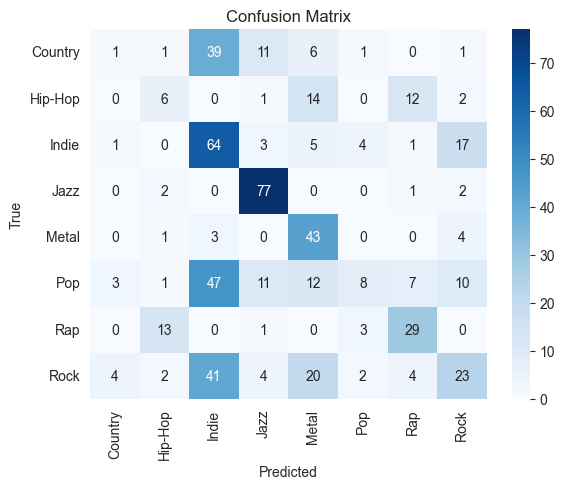

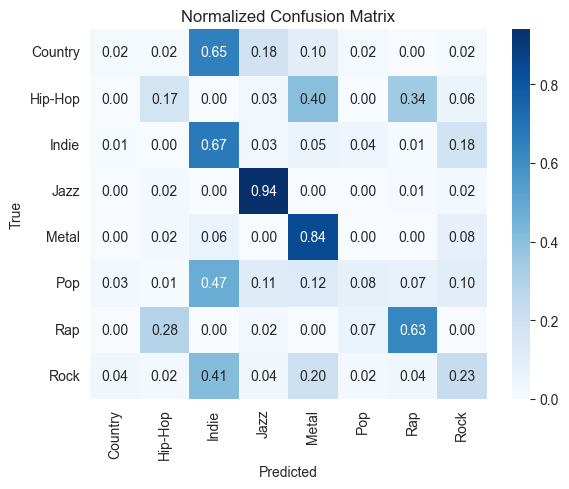

In [242]:
# True labels
true_labels = audio_labels
 # Assuming all labels are the same

# Accuracy
accuracy = accuracy_score(true_labels, final_preds)
print(f"Weighted Voting Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, final_preds, target_names=label_encoder.classes_))

# F1 score
f1 = f1_score(true_labels, final_preds, average="weighted")
print(f"Weighted Voting F1 Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, final_preds)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Normalize the confusion matrix
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [121]:
true_labels[0]

0

In [45]:
# Get lyrics true labels
lyrics_true_labels = np.argmax(y_lyrics, axis=1)

In [46]:
lyrics_true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [47]:
# Get audio true labels
audio_true_labels = mel_dataset.labels
audio_true_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,


In [48]:
# Get metadata true labels
metadata_true_labels = y_metadata

In [49]:
metadata_true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [50]:
# check metadata_true_labels == lyrics_true_labels == audio_true_labels
metadata_true_labels == lyrics_true_labels

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [51]:
audio_true_labels == lyrics_true_labels

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,